# 사람의 동작 분류
- 핸드폰 센서 데이터 분류
- Conv1D CNN 사용

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone_human.txt.zip\
    -o smartphone_human.txt.zip
# !curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  5107k      0  0:00:03  0:00:01  0:00:02 2758k      0  0:00:02  0:00:02 --:--:-- 5107k


In [3]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
  inflating: __MACOSX/._smartphone_human.txt  


In [4]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [5]:
!head -5 smartphone_human.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [6]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)

In [7]:
df[:2]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [9]:
# 1개의 결측치가 있다
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

/Users/hwa-kim/opt/anaconda3/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


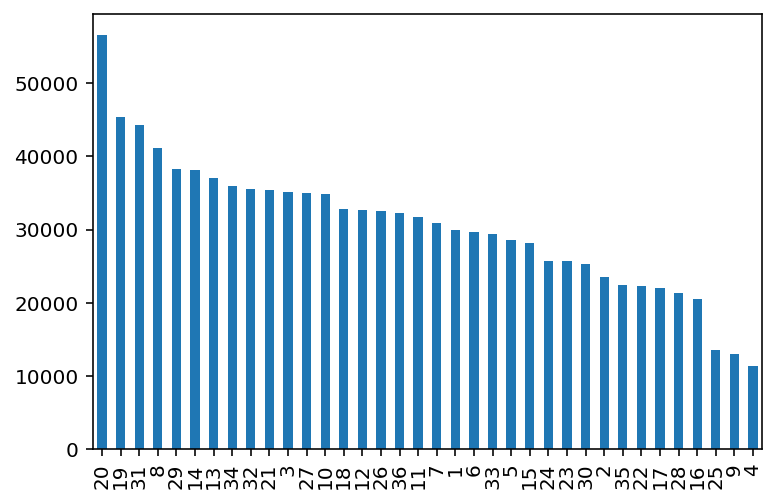

In [12]:
df['user-id'].value_counts().plot(kind='bar')

In [13]:
df["user-id"].nunique()

36

In [14]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

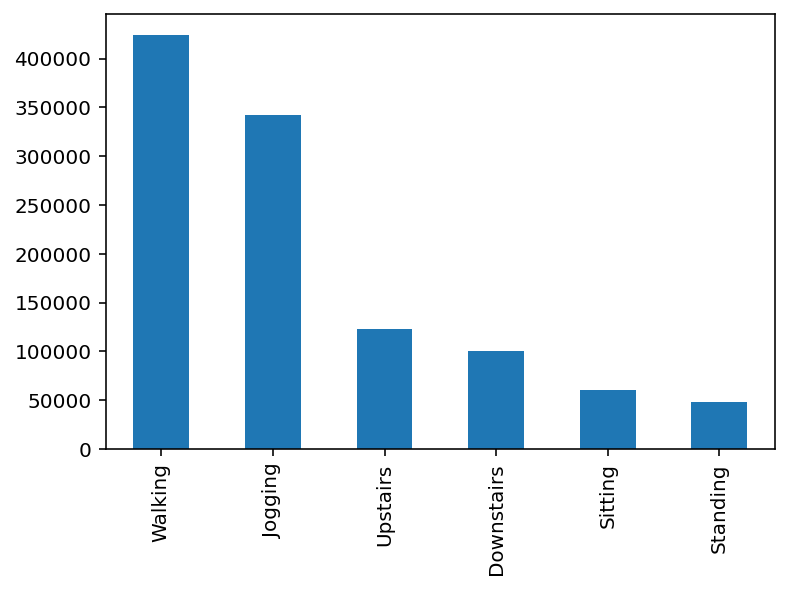

In [15]:
df['activity'].value_counts().plot(kind='bar')
plt.show()

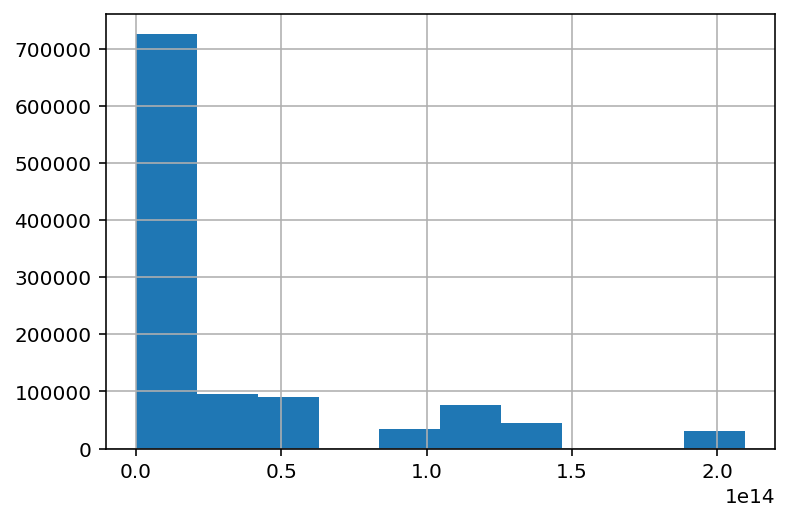

In [16]:
df['timestamp'].hist()

In [17]:
(df['timestamp'] == 0).sum()

12843

In [18]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

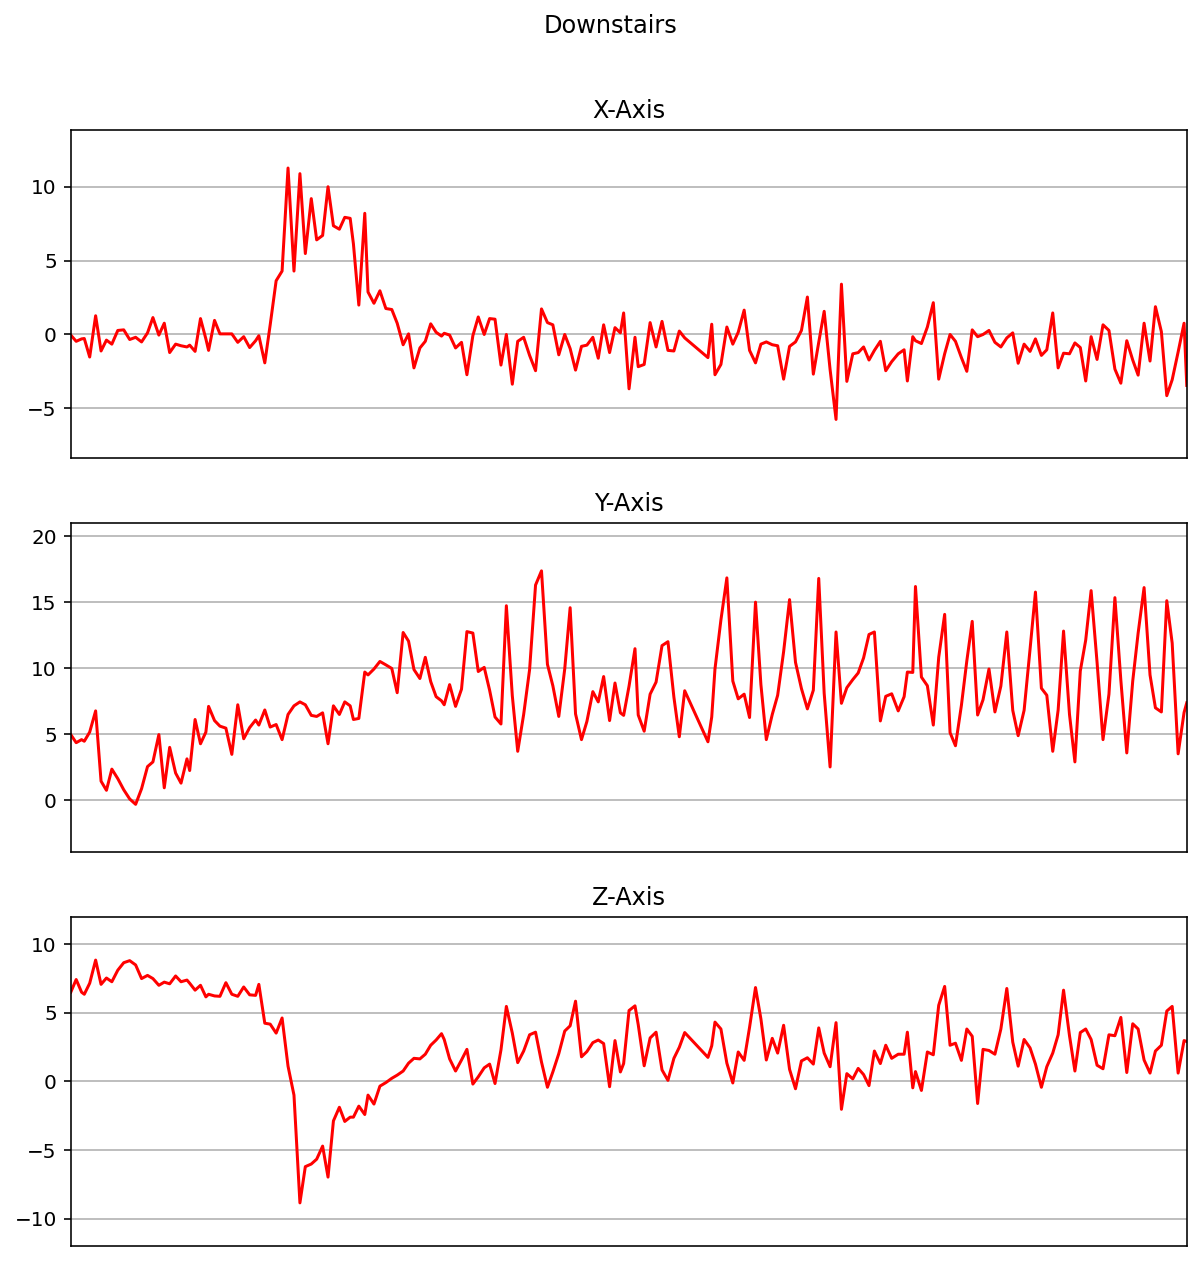

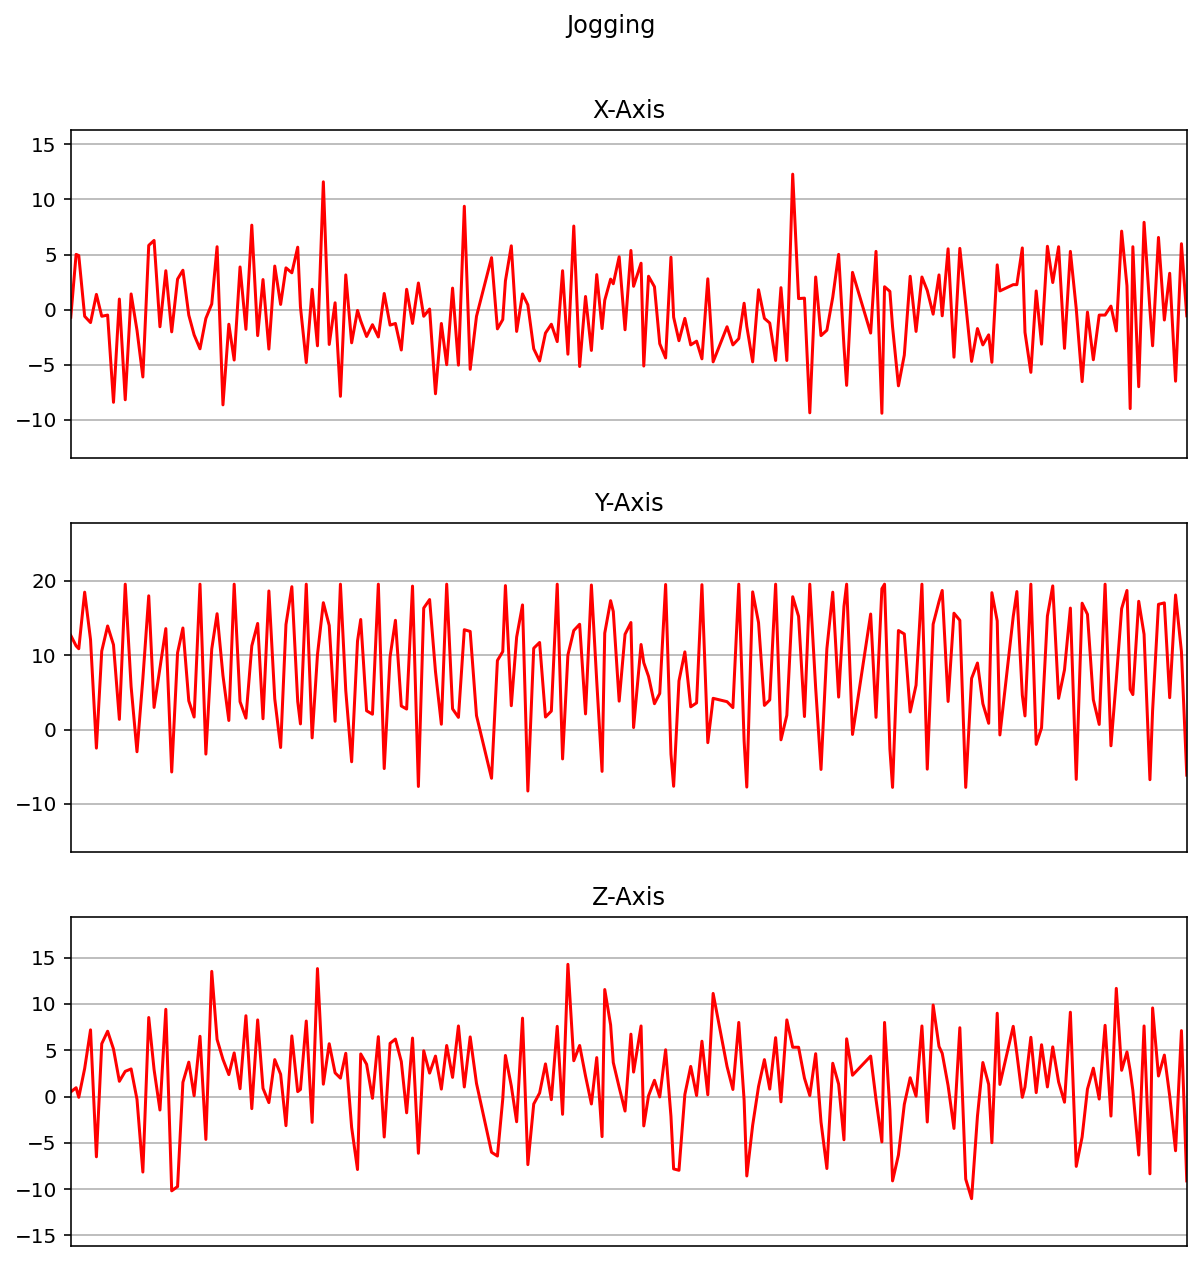

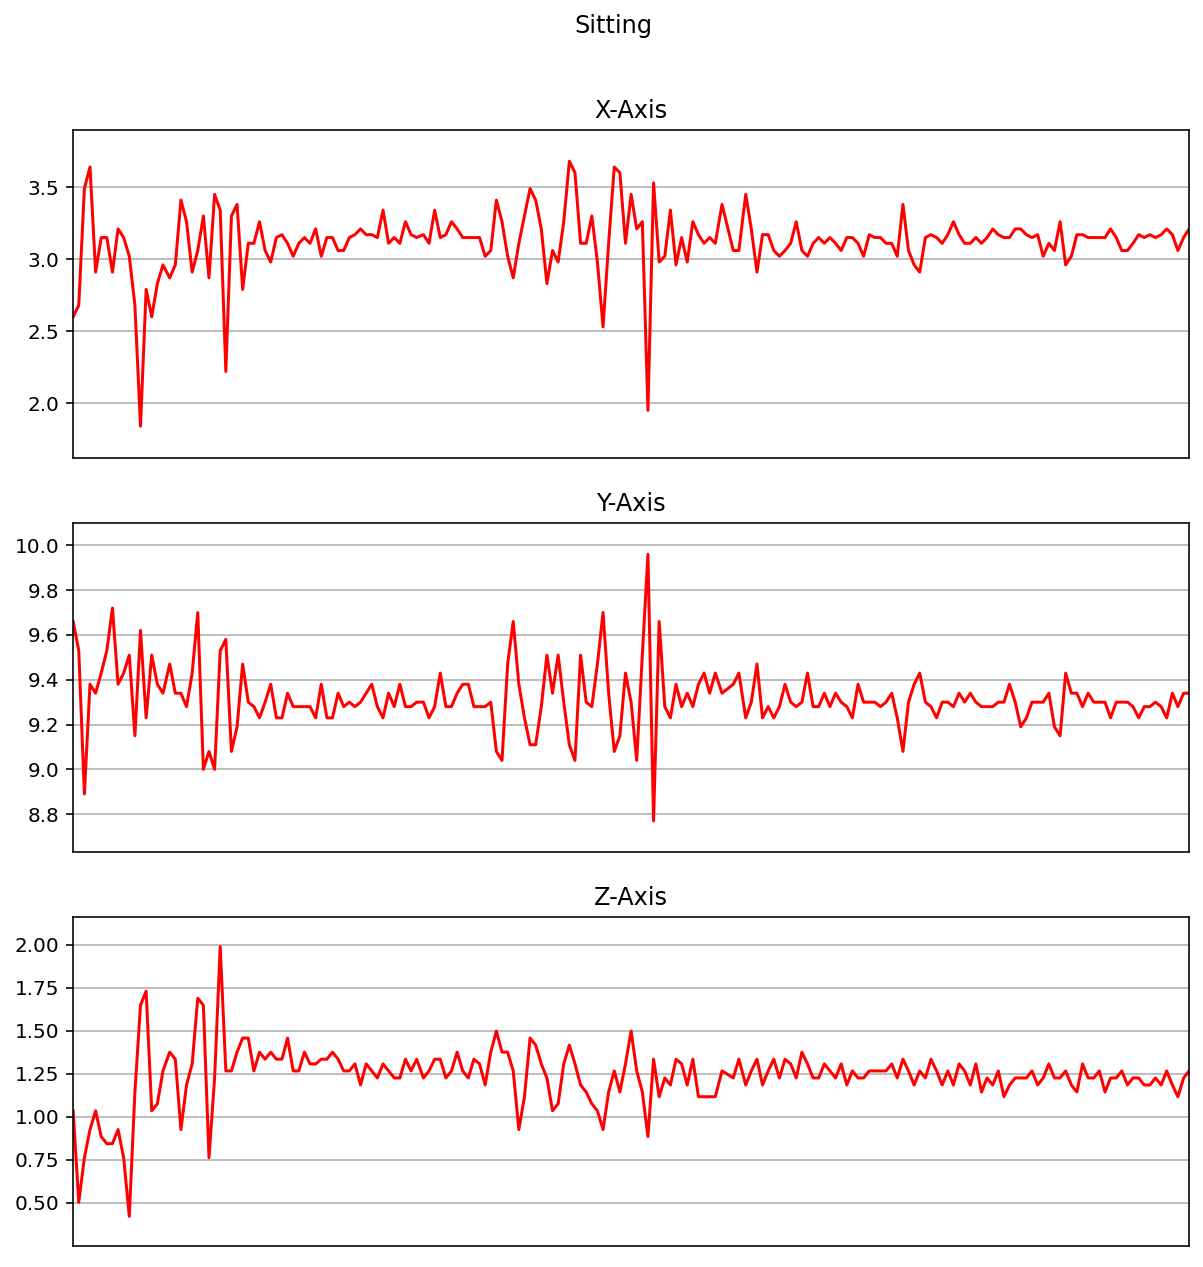

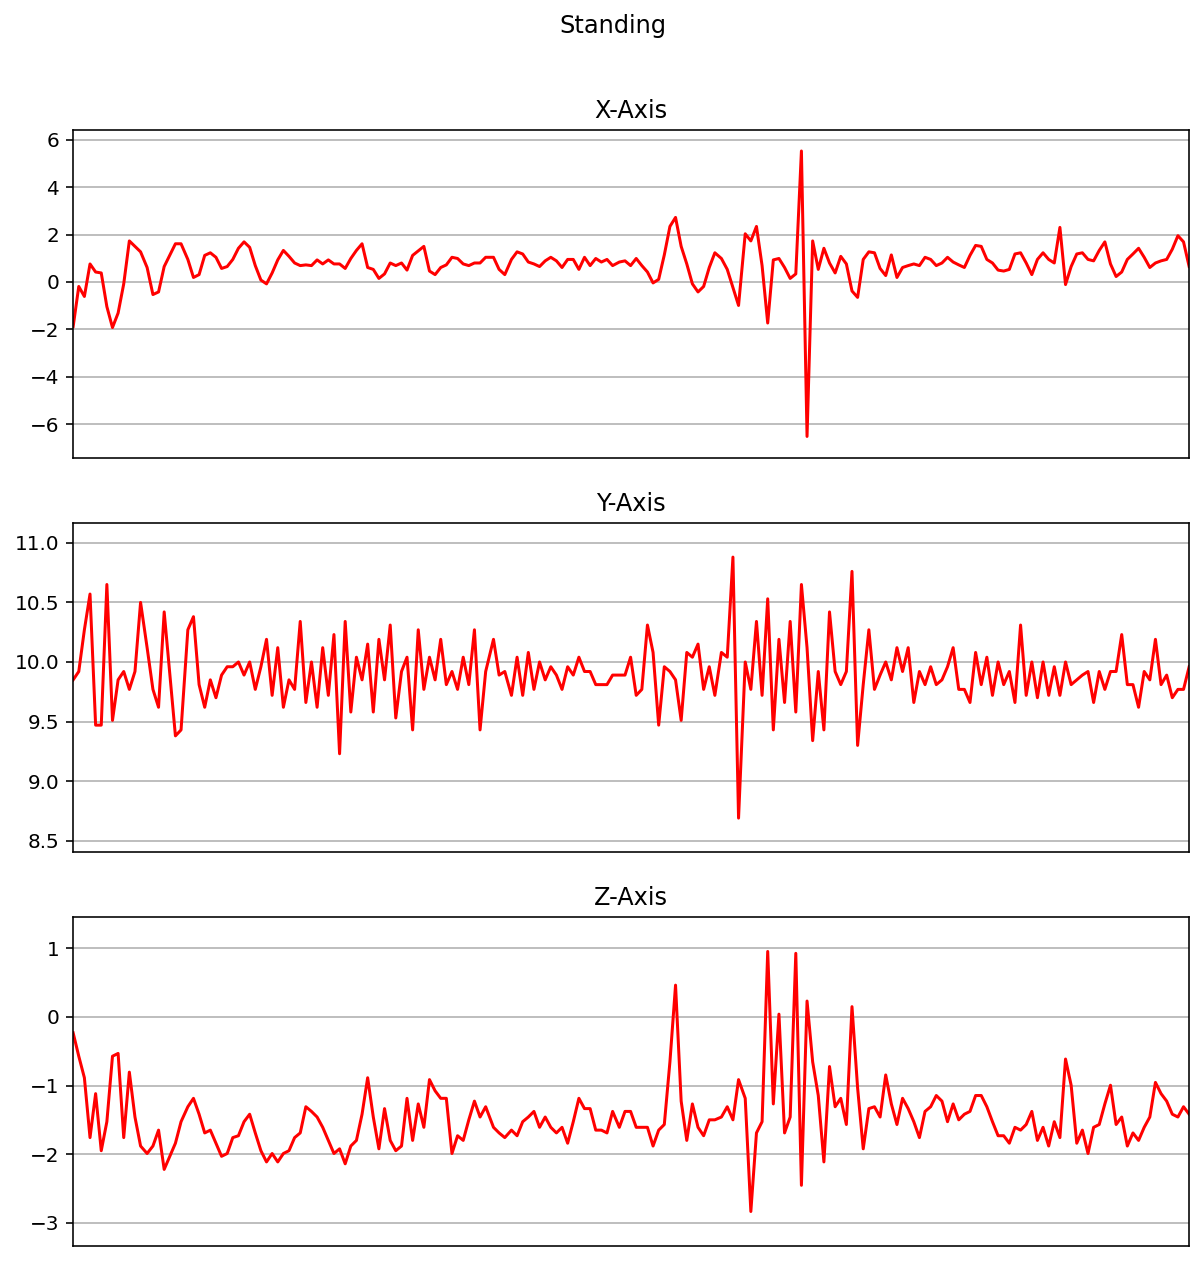

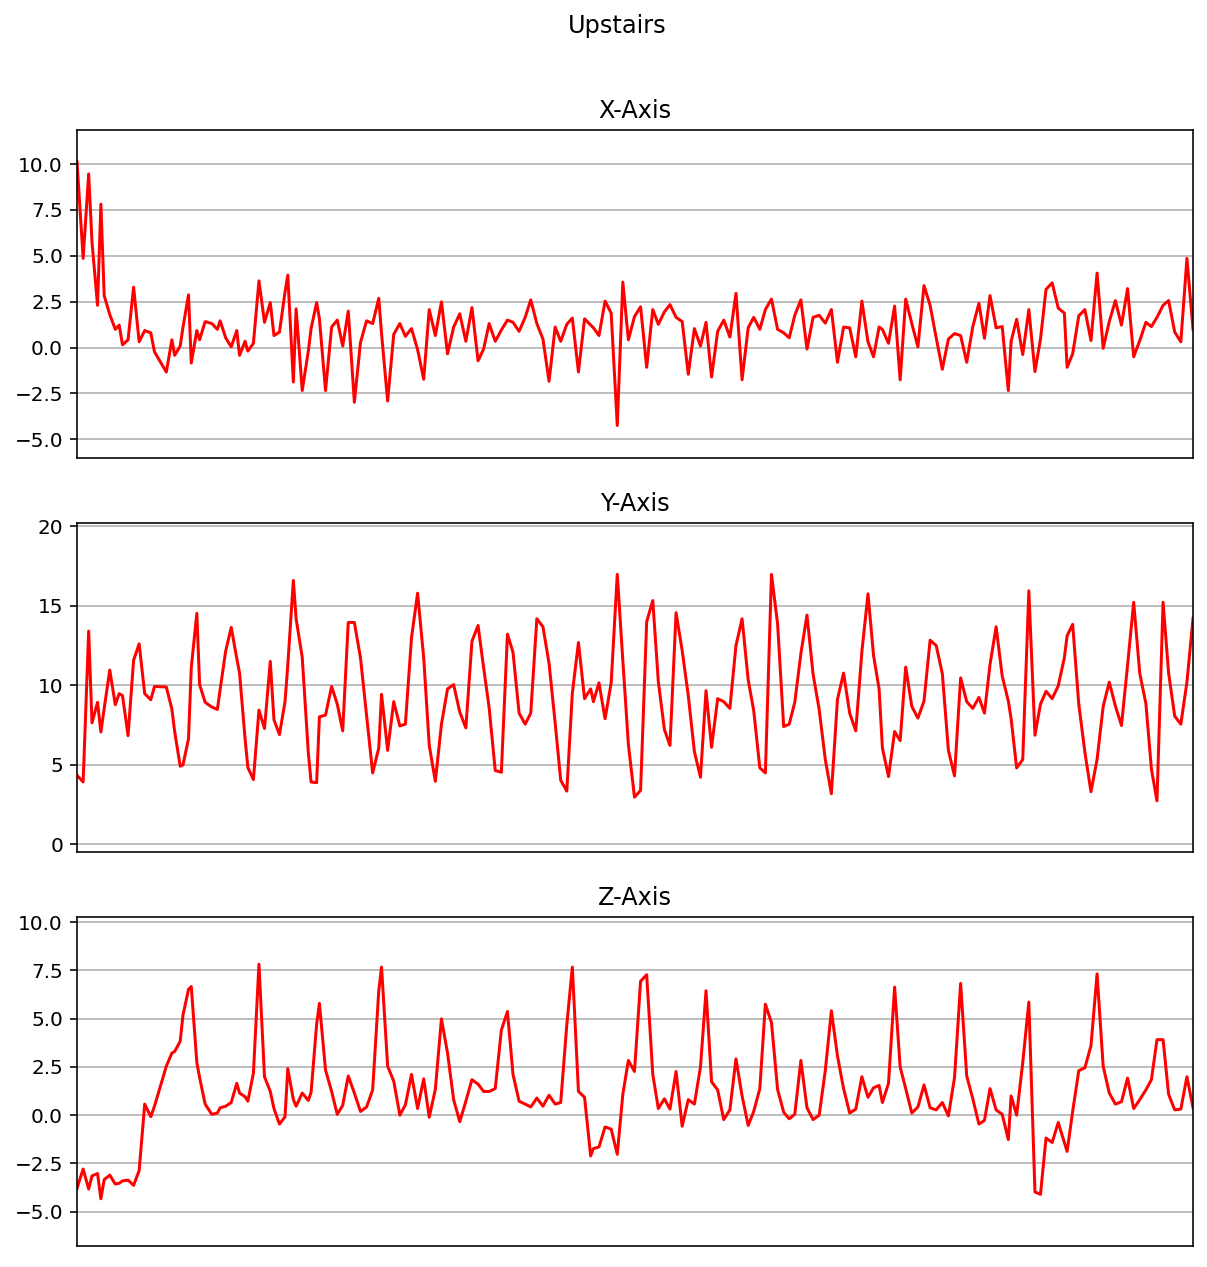

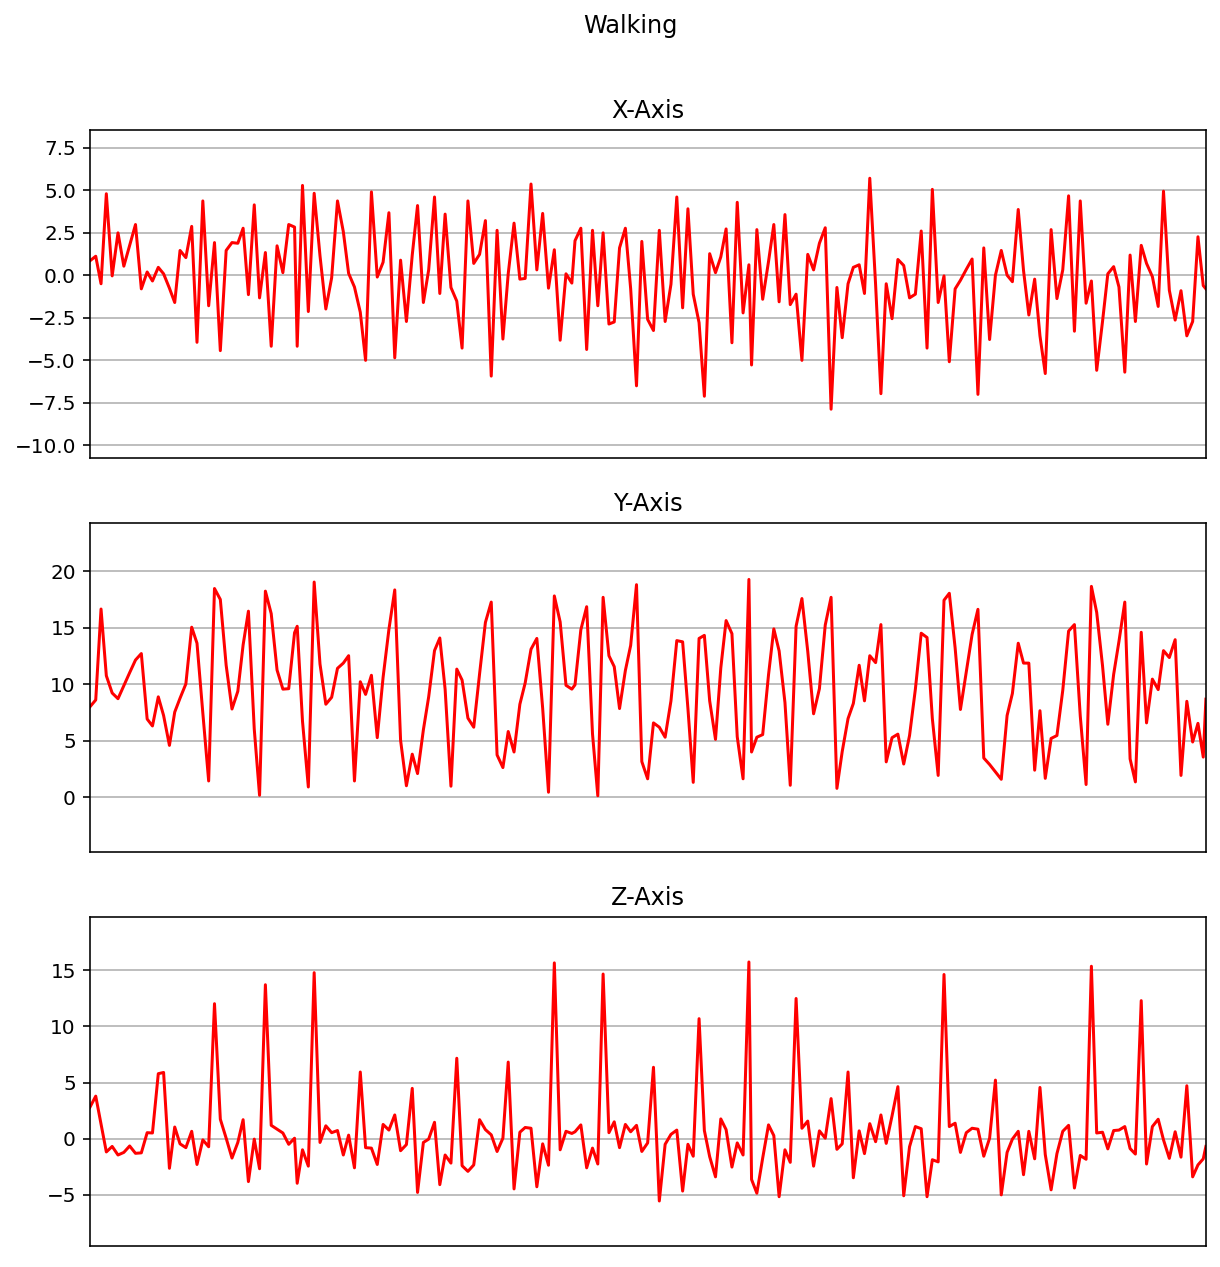

In [19]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [20]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [21]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [22]:
test = [1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2]
m = stats.mode(test) # 최빈값
m

ModeResult(mode=array([1]), count=array([12]))

In [23]:
m[1][0]

12

In [24]:
m[0][0], m[1][0]

(1, 12)

In [25]:
z = stats.mode(df['act'][100:200]) # 5초간 관찰
z[0][0], z[1][0]

(1, 100)

In [26]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [27]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


## 훈련 데이터 검증 데이터 나누기

In [28]:
(df['user-id'] < 28).mean()

0.7410978845728606

In [29]:
(df['user-id'] >= 28).mean()

0.25890211542713937

In [30]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]
# 랜덤하게 추출하는 것이 원칙, choice() 사용

In [31]:
def get_xy(N, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append(np.array([xs, ys, zs]).T)
            y.append(action)
    return np.array(X), np.array(y)

In [32]:
N = 100
X_train, y_train = get_xy(N, df_train)

In [33]:
X_test, y_test = get_xy(N, df_test)

In [34]:
X_train.shape, X_test.shape

((7752, 100, 3), (2713, 100, 3))

In [35]:
y_train.shape, y_test.shape

((7752,), (2713,))

In [36]:
X_train[:1]

array([[[-0.01432029,  0.36578464, -0.19806219],
        [-0.09735819,  0.42237274, -0.20660706],
        [-0.13096877,  0.37184764, -0.23224165],
        [-0.07561017,  0.40620484, -0.19236561],
        [-0.07561017,  0.41630974, -0.21515192],
        [-0.00838901,  0.38801569, -0.23224165],
        [-0.08154145,  0.39407869, -0.19236561],
        [-0.11317493,  0.40014184, -0.19806219],
        [-0.10922075,  0.41226784, -0.16673101],
        [-0.05188505,  0.39407869, -0.21515192],
        [-0.04793087,  0.39407869, -0.20660706],
        [-0.04199959,  0.40620484, -0.19806219],
        [-0.05781633,  0.40014184, -0.19236561],
        [-0.04199959,  0.39407869, -0.21515192],
        [-0.02420575,  0.40014184, -0.21515192],
        [-0.03013703,  0.39407869, -0.17527588],
        [-0.02420575,  0.39407869, -0.17527588],
        [-0.04199959,  0.39407869, -0.15818614],
        [-0.05188505,  0.38801569, -0.16673101],
        [-0.02025157,  0.38801569, -0.17527588],
        [-0.02025157

In [37]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## 랜덤 포레스트

In [40]:
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.6321415407298194

# MLP

In [41]:
# 2차원 테이블 구조의 X만 사용한다

model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [42]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

In [43]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
   

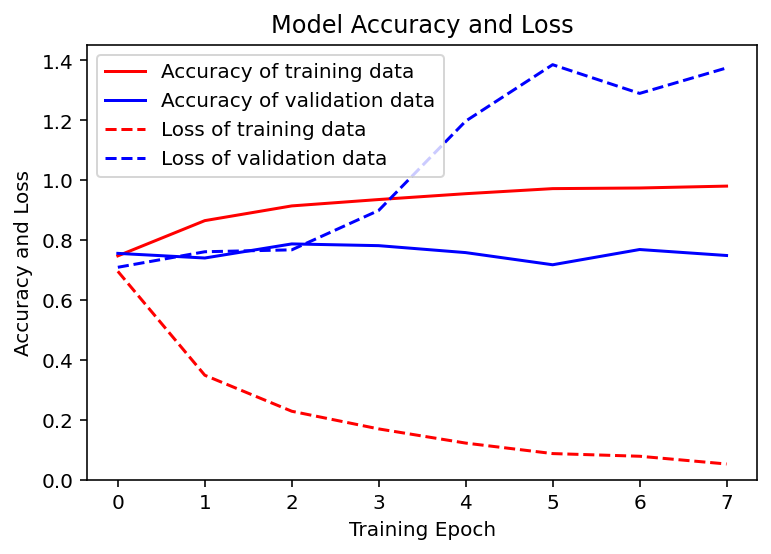

In [44]:
show_4_graphs(h)

In [45]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [46]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))   

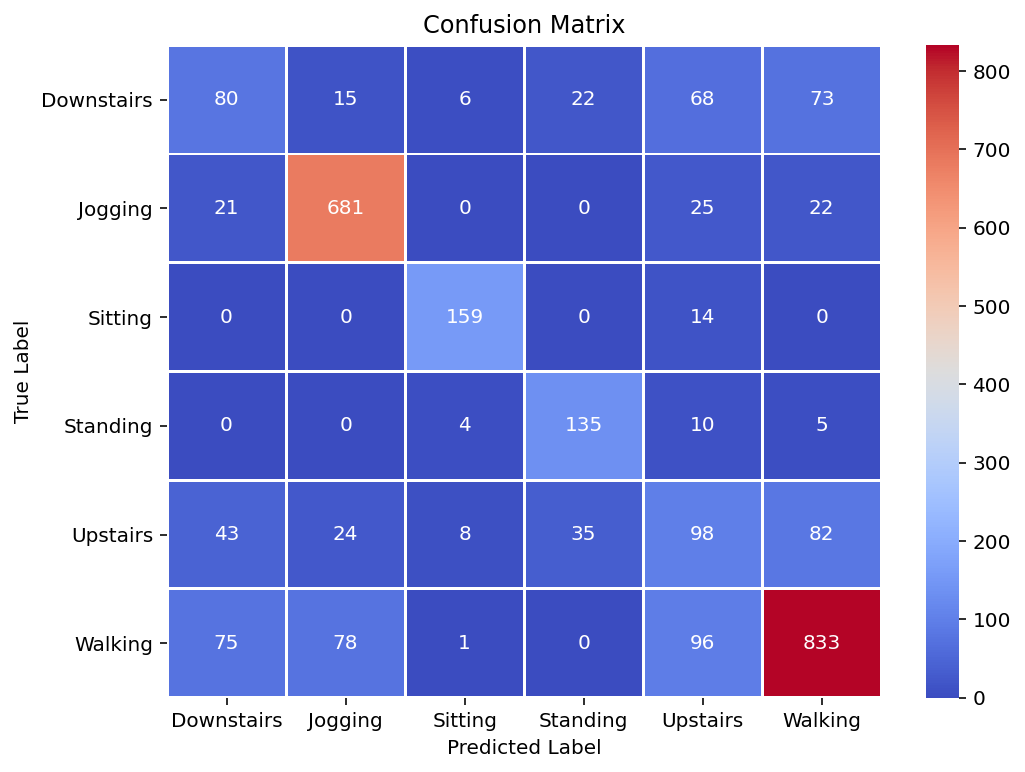

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       264
           1       0.85      0.91      0.88       749
           2       0.89      0.92      0.91       173
           3       0.70      0.88      0.78       154
           4       0.32      0.34      0.33       290
           5       0.82      0.77      0.79      1083

    accuracy                           0.73      2713
   macro avg       0.66      0.69      0.67      2713
weighted avg       0.73      0.73      0.73      2713



In [47]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# CNN (Conv1D)

In [48]:
# (sample, shape, features) 구조 사용
model_m = Sequential()
model_m.add(Conv1D(16, 2, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(32, 4, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(64, 8, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Flatten())
model_m.add(Dropout(0.3))
model_m.add(Dense(1)  # y_pred (ttf) 세시간 회귀분석
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 16)            112       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 64)            16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [49]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
311/311 [==============================] - 32s 5ms/step - loss: 0.8961 - accuracy: 0.6424 - val_loss: 0.7280 - val_accuracy: 0.8130
Epoch 2/30
311/311 [==============================] - 1s 4ms/step - loss: 0.2799 - accuracy: 0.8944 - val_loss: 0.8949 - val_accuracy: 0.7917
Epoch 3/30
311/311 [==============================] - 1s 4ms/step - loss: 0.1701 - accuracy: 0.9436 - val_loss: 0.8663 - val_accuracy: 0.8150
Epoch 4/30
311/311 [==============================] - 1s 4ms/step - loss: 0.1191 - accuracy: 0.9591 - val_loss: 1.0052 - val_accuracy: 0.7769
Epoch 5/30
311/311 [==============================] - 1s 4ms/step - loss: 0.0892 - accuracy: 0.9728 - val_loss: 1.0940 - val_accuracy: 0.7801
Epoch 6/30
311/311 [==============================] - 1s 4ms/step - loss: 0.0770 - accuracy: 0.9747 - val_loss: 0.9972 - val_accuracy: 0.8362
Epoch 7/30
311/311 [==============================] - 1s 4ms/step - loss: 0.0623 - accuracy: 0.9849 - val_loss: 1.0366 - val_accuracy: 0.7975
Epoch

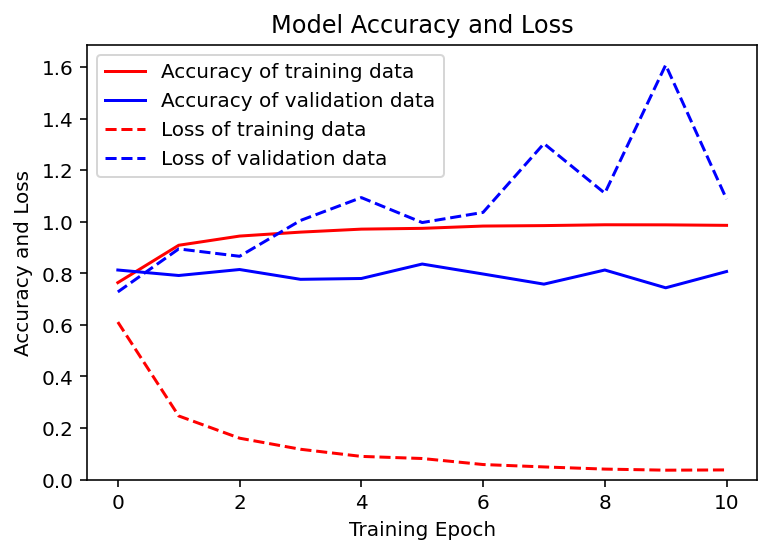

In [50]:
show_4_graphs(history)

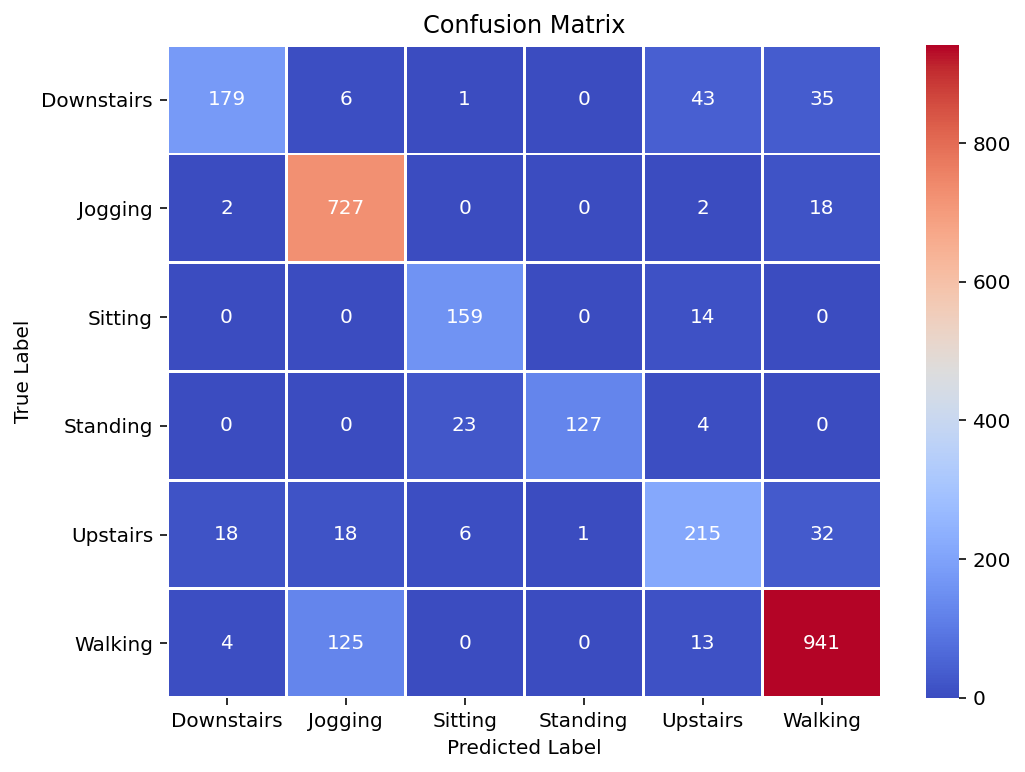

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       264
           1       0.83      0.97      0.89       749
           2       0.84      0.92      0.88       173
           3       0.99      0.82      0.90       154
           4       0.74      0.74      0.74       290
           5       0.92      0.87      0.89      1083

    accuracy                           0.87      2713
   macro avg       0.87      0.83      0.85      2713
weighted avg       0.87      0.87      0.86      2713



In [51]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# RNN
- 참고 사항
- 시계열 예측에는 우수하나 패턴 찾기에는 CNN이 더 우수함

In [52]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

In [53]:
history = model.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
311/311 [==============================] - 12s 17ms/step - loss: 1.0060 - accuracy: 0.6445 - val_loss: 0.8716 - val_accuracy: 0.6873
Epoch 2/30
311/311 [==============================] - 5s 15ms/step - loss: 0.3125 - accuracy: 0.8827 - val_loss: 1.2731 - val_accuracy: 0.7421
Epoch 3/30
311/311 [==============================] - 5s 15ms/step - loss: 0.2232 - accuracy: 0.9243 - val_loss: 0.5635 - val_accuracy: 0.8208
Epoch 4/30
311/311 [==============================] - 5s 15ms/step - loss: 0.2753 - accuracy: 0.8947 - val_loss: 1.0381 - val_accuracy: 0.7324
Epoch 5/30
311/311 [==============================] - 5s 15ms/step - loss: 0.1300 - accuracy: 0.9565 - val_loss: 0.8556 - val_accuracy: 0.7240
Epoch 6/30
311/311 [==============================] - 5s 15ms/step - loss: 0.1098 - accuracy: 0.9623 - val_loss: 1.0572 - val_accuracy: 0.7608


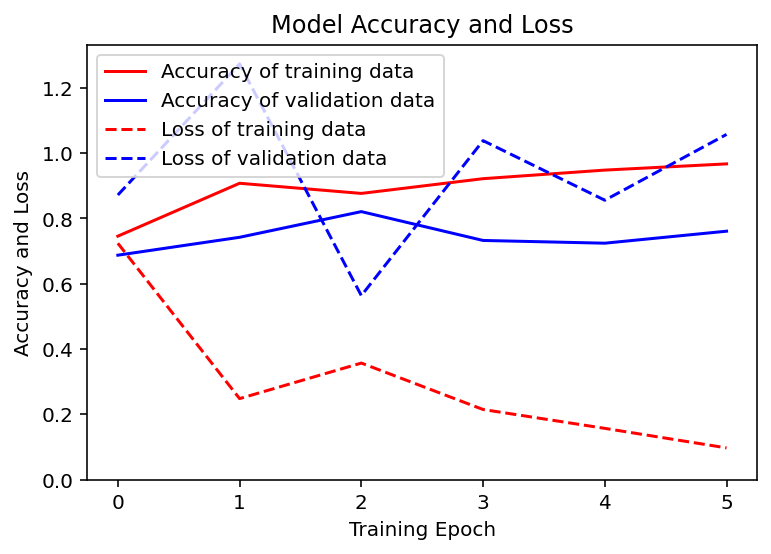

In [54]:
show_4_graphs(history)

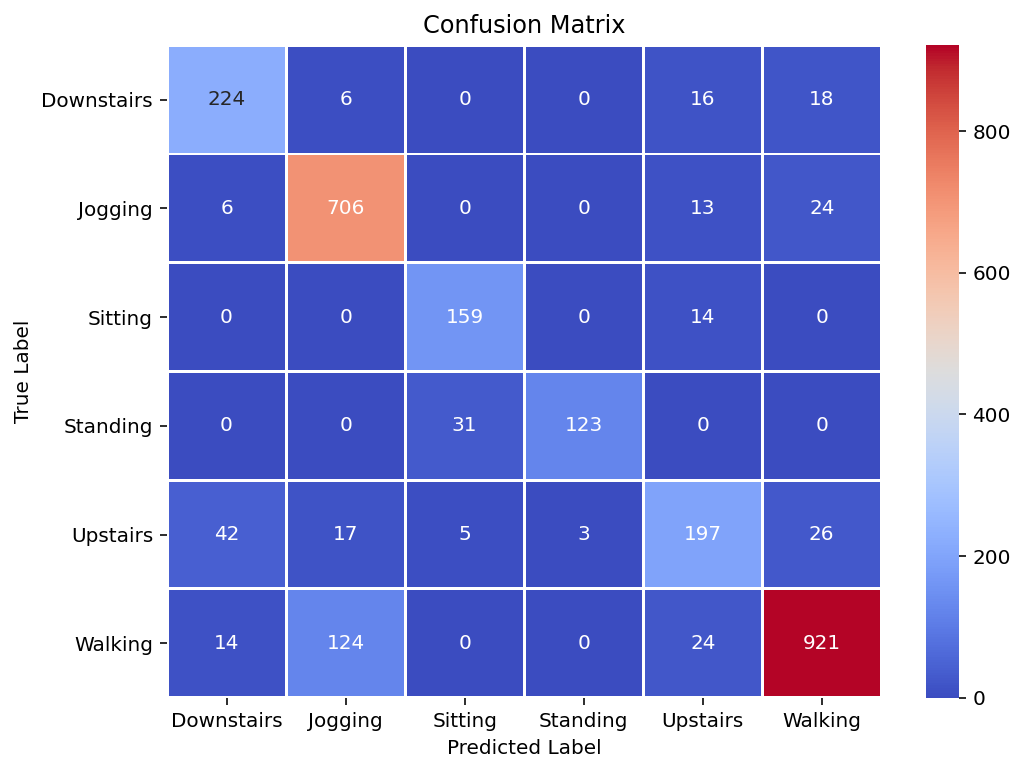

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       264
           1       0.83      0.94      0.88       749
           2       0.82      0.92      0.86       173
           3       0.98      0.80      0.88       154
           4       0.75      0.68      0.71       290
           5       0.93      0.85      0.89      1083

    accuracy                           0.86      2713
   macro avg       0.85      0.84      0.84      2713
weighted avg       0.86      0.86      0.86      2713



In [55]:
y_pred = model.predict(X_test)
show_results(y_test, y_pred)